# Exploratory Data Analysis

In this notebook we take a broad look at the return characteristics across the asset classes considered in the analysis.

We are looking for data integrity problems and a general sense of what may influence the return attribution from allocation decisions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20, 12
sns.set(style="whitegrid", palette=None, rc={"figure.figsize":(20, 12)})

In [2]:
benchmark_weights = pd.read_excel(
    io="../data/raw/Technical Test - Portfolio Attribution.xlsm",
    sheet_name="Benchmark Weights",
    header=[0, 1],
    index_col=0)

saa_weights = pd.read_excel(
    io="../data/raw/Technical Test - Portfolio Attribution.xlsm",
    sheet_name="SAA Weights",
    header=[0, 1],
    index_col=0)

manager_weights = pd.read_excel(
    io="../data/raw/Technical Test - Portfolio Attribution.xlsm",
    sheet_name="Manager Weights",
    header=[0, 1, 2],
    index_col=0)

returns = pd.read_csv("../data/interim/returns.csv", header=[0, 1], index_col=[0])

In [3]:
# todo find better way to suppress copy warning
pd.set_option('mode.chained_assignment', None)

# wrangling to reset fund f to its original timeline since we set the values to 0 in cleaning
fund_returns = returns['Fund Total Returns (CAD)']
fund_f_vector = fund_returns.copy().reset_index().apply(lambda row: row["Fund F"] if pd.to_datetime(row["index"]) > pd.to_datetime('2021-05-02') else np.NAN, axis=1)
fund_f_vector.index = fund_returns.index
fund_returns['Fund F'] = fund_f_vector
returns['Fund Total Returns (CAD)'] = fund_returns

## Daily return distributions

Here we observe results fairly consistent with what we would expect. Equities and equity-based funds (A-H) have higher volatility than the Fixed Income assets and their funds. 

Notably, US Equities and in particular Fund D seem to have had the most favourable right skewed performance over the time period. Outperformance of benchmarks may be particularly linked with the extent to which allocation favours US equities and Fund D. Fund F seems to have the worst performance but we must keep in mind that its time period starts later and thus potentially misses the pandemic recovery returns which limits comparability. Fund H has remarkably low volatility considering it is based on emerging market equities.

/home/julien/miniconda3/envs/portfolio_attribution/lib/python3.11/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


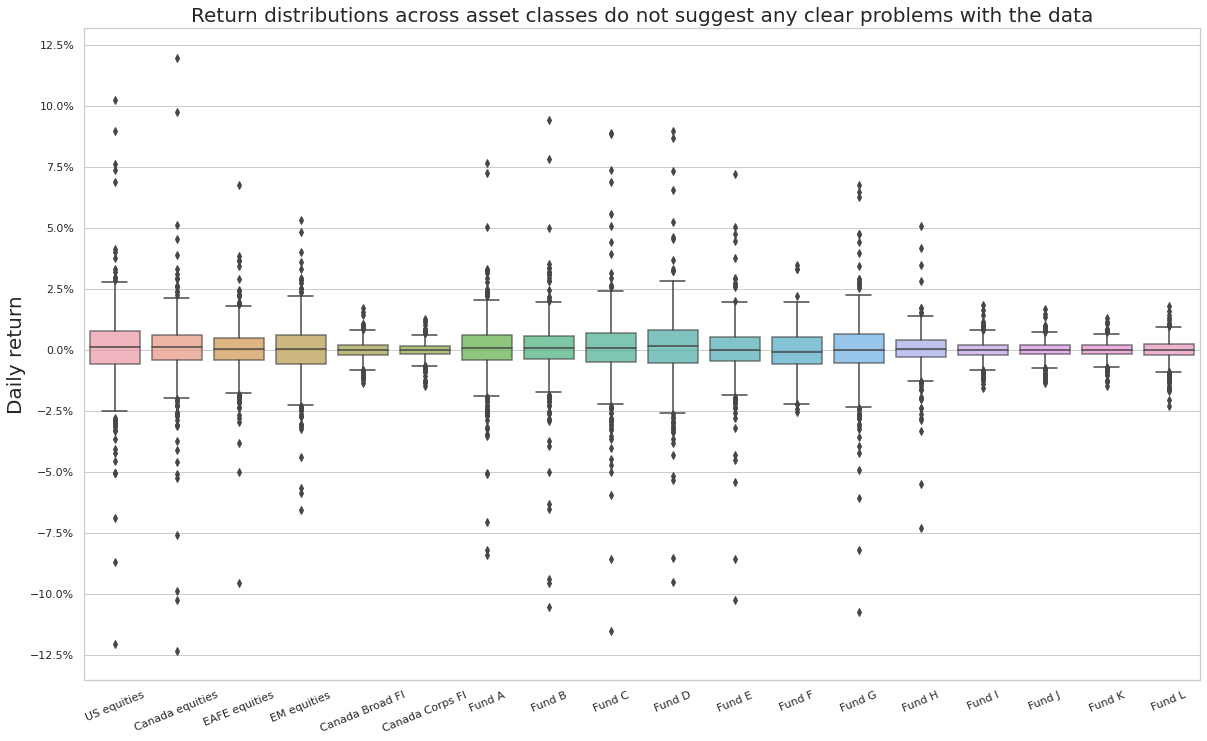

In [4]:
# TODO Colour boxes by Equities vs FI
fig, ax = plt.subplots(figsize=(20, 12))
sns.boxplot(data=returns.droplevel(0, axis=1) * 100, boxprops=dict(alpha=0.7)).set(yticks=np.linspace(-12.5, 12.5, 11))
plt.xticks(rotation=22.5);
plt.ylabel("Daily return", size=20)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Return distributions across asset classes do not suggest any clear problems with the data", size=20);

In [5]:
fund_index_lookup = {"Fund A": "Canada equities",
        "Fund B": "Canada equities",
        "Fund C": "US equities",
        "Fund D": "US equities",
        "Fund E": "EAFE equities",
        "Fund F": "EAFE equities",
        "Fund G": "EM equities",
        "Fund H": "EM equities",
        "Fund I": "Canada Broad FI",
        "Fund J": "Canada Broad FI",
        "Fund K": "Canada Corps FI",
        "Fund L": "Canada Corps FI"}

pd.DataFrame.from_dict(fund_index_lookup, orient="index")

,0
Fund A,Canada equities
Fund B,Canada equities
Fund C,US equities
Fund D,US equities
Fund E,EAFE equities
Fund F,EAFE equities
Fund G,EM equities
Fund H,EM equities
Fund I,Canada Broad FI
Fund J,Canada Broad FI


## Time Series of Returns

Looking at broad time series of daily/monthly returns is a bit difficult to extract much information but we can see that there was higher volatility in the beginning and end of our time period. It seems, however, that there may be the most oppourtunity to add value from active allocation decisions during the low volatilty components of the series, where it seems as though there is a wider spread between assets as compared to the high volatility sections where spikes and troughs show high correlation between assets and "squeezing" of average returns in somewhat narrow bands. 

In [6]:
returns.index = pd.to_datetime(returns.index)

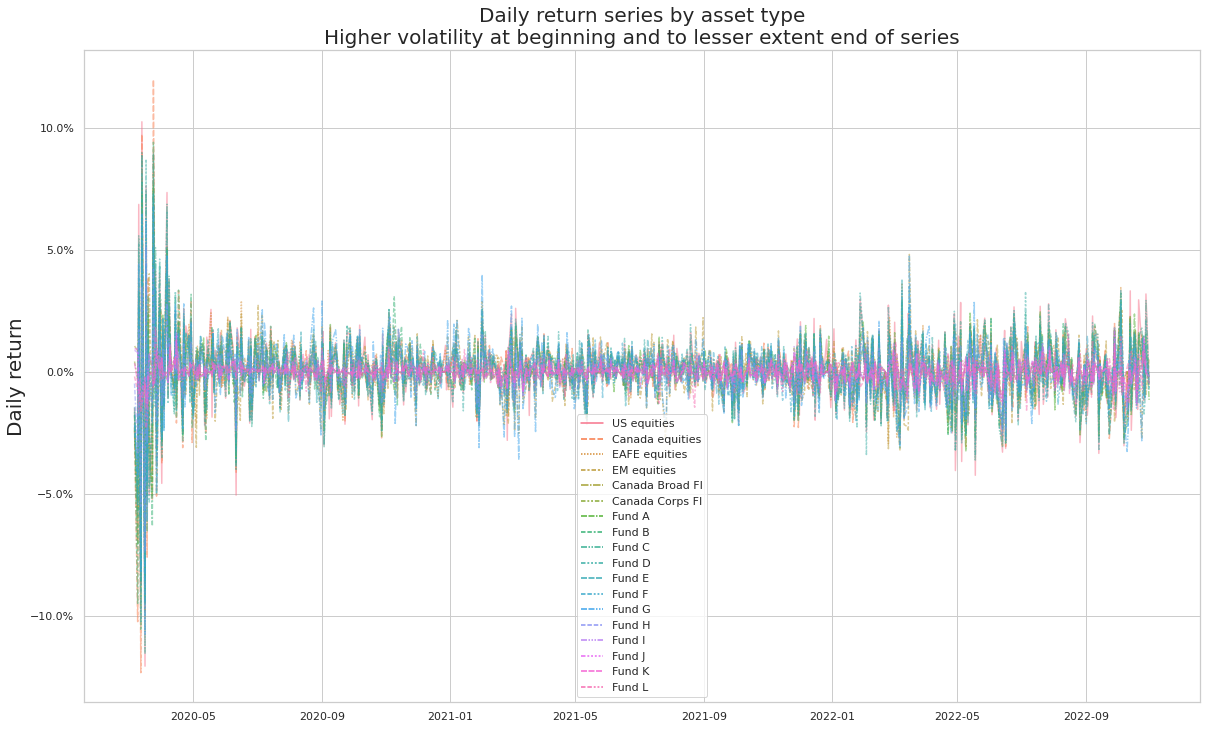

In [7]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.lineplot(data=returns.droplevel(0, axis=1) * 100, alpha=0.5);
plt.ylabel("Daily return", size=20)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Daily return series by asset type\nHigher volatility at beginning and to lesser extent end of series", size=20);

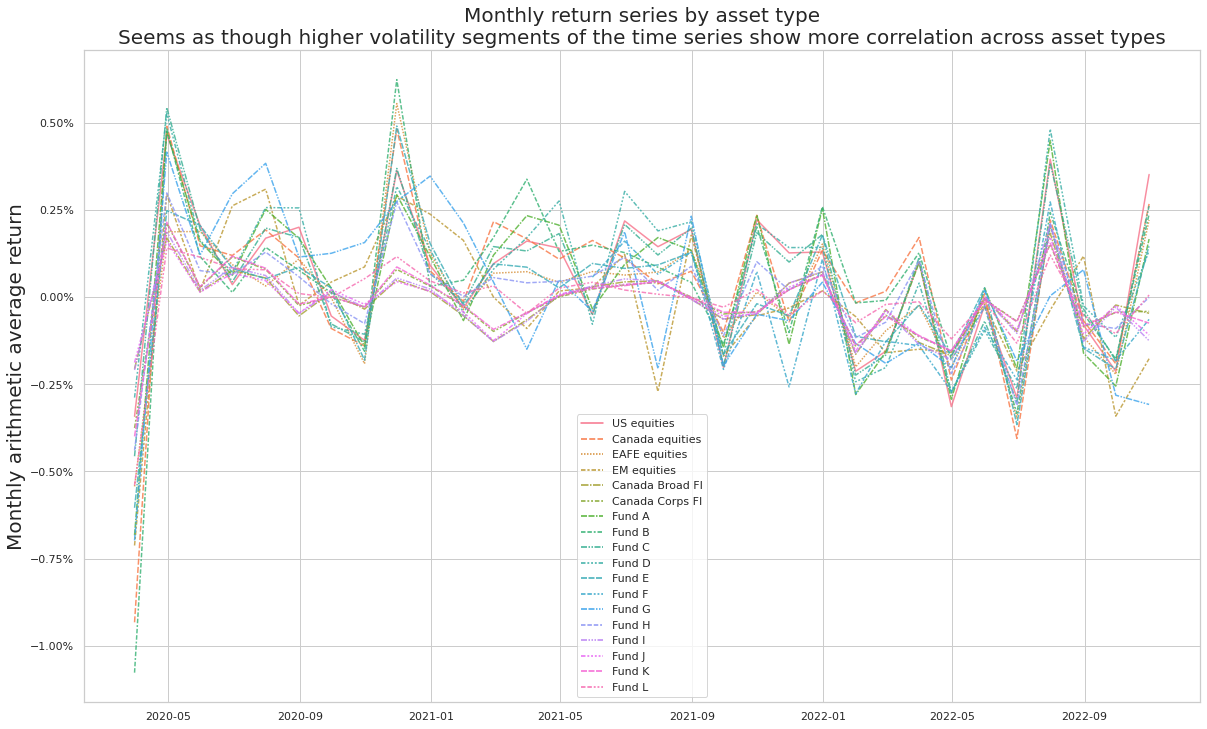

In [8]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.lineplot(data=returns.resample('M').mean().droplevel(0, axis=1) * 100, alpha=0.8);
plt.ylabel("Monthly arithmetic average return", size=20)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Monthly return series by asset type\nSeems as though higher volatility segments of the time series show more correlation across asset types", size=20);

## Findings from correlation heatmap - Style Drift Red Flags

Mostly we see what we would expect. There are generally high corellations within equity related classes, particularly for Canadian and US equities. There is a very high degree of correlation between the FI asset types. 

Most of the fund correlations are what we would expect but there are a couple of red flags with respect to potential style drift which arise from looking at the correlation of the funds with their supposed assets from which they are derived. In particular, Fund L is supposed to be a Canadian corporate fixed income based fund but has very limited correlation with any asset class, although most correlated with Canadian FI Corps. Fund H is supposed to be an EM equity fund but we see that it has correlations with Canadian and US equities which are comparable to that of the funds which are supposed to be based on Canadian and US equities. Fund H investments in particular may be offering a false sense of diversification. 

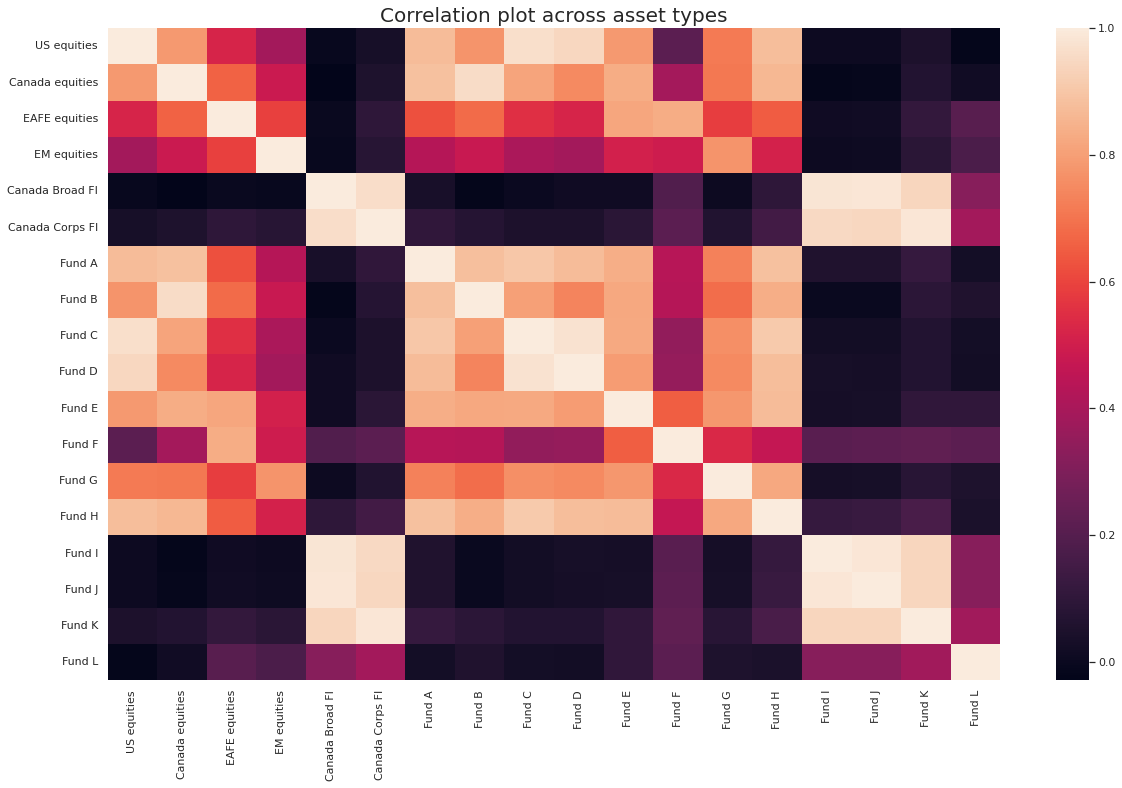

In [9]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(returns.droplevel(0, axis=1).corr())
plt.title("Correlation plot across asset types", size=20);

In [10]:
pd.DataFrame.from_dict(fund_index_lookup, orient="index")

,0
Fund A,Canada equities
Fund B,Canada equities
Fund C,US equities
Fund D,US equities
Fund E,EAFE equities
Fund F,EAFE equities
Fund G,EM equities
Fund H,EM equities
Fund I,Canada Broad FI
Fund J,Canada Broad FI
